In [1]:
import os
import sys
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
from scipy.stats import pearsonr
import toolsets.spectra_operations as so
from toolsets.file_io import get_file_list, readin_peak_list, prepare_sample_list
from toolsets.ff_droup import process_mzml, get_EIC_list, EIC
from toolsets.feature_alignment import initilize_pmz_rt_list, find_feature, find_istd, clean_bad_features
from feature_normalization.rt_normalization import rt_normalization
from tqdm import tqdm
import seaborn as sns
from toolsets.biodata import find_edge, biodata_prep
import matplotlib.pyplot as plt
import toolsets.ff_droup as ff
# from toolsets.feature_alignment import
from toolsets.search import quick_search_values, string_search
# from feature_finding.feature_finding_alphapept import find_feature

# Bio_data analysis

In [2]:
bio_dir = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/20230607_NQ_Development_H2Lv2/bioactivity/pos'
bio_data = pd.read_csv(os.path.join(bio_dir, 'H2L000022-1 Bioactivity - E.coli.csv'))
bio_data_processed =biodata_prep(bio_data)

In [4]:
bio_data_processed

,Well Number,mix,OD600-1,OD600-2,Average,Stdev,average_adjusted,pos_p_value,neg_p_value,peak_label
0,A1,LH20_X1,1.519,1.510,1.515,0.006,0.000,0.000208,0.929893,False
1,A2,LH20_X2,1.468,1.272,1.370,0.139,0.000,0.000539,0.847887,False
2,A3,LH20_X3,1.622,1.231,1.427,0.276,0.000,0.000433,0.881982,False
3,A4,LH20_X4,1.401,1.462,1.432,0.043,0.000,0.000350,0.889574,False
4,A5,LH20_X5,1.601,1.238,1.420,0.257,0.000,0.000441,0.878386,False
5,A6,LH20_X6,1.701,1.132,1.417,0.402,0.000,0.000558,0.870646,False
6,A7,LH20_X7,1.909,1.131,1.520,0.550,0.000,0.000406,0.916874,False
7,A8,LH20_X8,1.742,1.376,1.559,0.259,0.000,0.000189,0.942623,False
8,A9,LH20_X9,0.050,0.075,0.063,0.018,1.854,0.661295,0.002421,True
9,A10,LH20_X10,0.052,0.046,0.049,0.004,1.868,0.678409,0.002220,True


<Axes: xlabel='mix', ylabel='average_adjusted'>

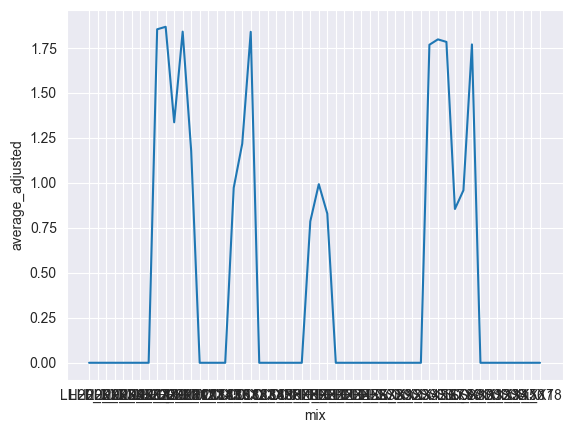

In [23]:
sns.lineplot(x = bio_data_processed['mix'], y = bio_data_processed['average_adjusted'])

In [5]:
alignment_dir = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/20230607_NQ_Development_H2Lv2/alignment_result/pos'
alignment = pd.read_csv(os.path.join(alignment_dir, 'alignment_result_cleaned.csv'))

In [6]:
bio_data_processed

,Well Number,mix,OD600-1,OD600-2,Average,Stdev,average_adjusted,pos_p_value,neg_p_value,peak_label
0,A1,LH20_X1,1.519,1.510,1.515,0.006,0.000,0.000208,0.929893,False
1,A2,LH20_X2,1.468,1.272,1.370,0.139,0.000,0.000539,0.847887,False
2,A3,LH20_X3,1.622,1.231,1.427,0.276,0.000,0.000433,0.881982,False
3,A4,LH20_X4,1.401,1.462,1.432,0.043,0.000,0.000350,0.889574,False
4,A5,LH20_X5,1.601,1.238,1.420,0.257,0.000,0.000441,0.878386,False
5,A6,LH20_X6,1.701,1.132,1.417,0.402,0.000,0.000558,0.870646,False
6,A7,LH20_X7,1.909,1.131,1.520,0.550,0.000,0.000406,0.916874,False
7,A8,LH20_X8,1.742,1.376,1.559,0.259,0.000,0.000189,0.942623,False
8,A9,LH20_X9,0.050,0.075,0.063,0.018,1.854,0.661295,0.002421,True
9,A10,LH20_X10,0.052,0.046,0.049,0.004,1.868,0.678409,0.002220,True


In [7]:
from toolsets.biodata import rank_features
correlation_result = rank_features(alignment, bio_data_processed)

100%|██████████| 45533/45533 [00:11<00:00, 4056.52it/s]


In [8]:
correlation_result

,rank,score,pmz,rt,correlation,max_values,p_values,annotation,feature_type,C18_X0_P,...,Si_X17_P,Si_X18_P,Si_X2_P,Si_X3_P,Si_X4_P,Si_X5_P,Si_X6_P,Si_X7_P,Si_X8_P,Si_X9_P
0,0,0.772315,282.0808,1.786313,0.862666,5.253042e+07,5.117004e-17,unknown,compound,1.299701e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.770530e+06,4.427643e+07,3.488873e+07,2.386953e+07,1.179156e+07,7.743314e+06
1,1,0.764599,301.0520,2.035756,0.856172,5.026337e+07,1.564579e-16,unknown,compound,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.094803e+06,5.026337e+07,2.537580e+07,2.029933e+07,1.170562e+07,8.537312e+06
2,2,0.760122,301.0519,2.299176,0.844756,5.749320e+07,9.833768e-16,unknown,compound,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.918329e+04,3.739106e+06,4.488483e+07,2.832714e+07,2.075457e+07,1.071021e+07,7.254112e+06
3,3,0.744985,398.0944,2.009664,0.846425,3.891418e+07,7.587225e-16,unknown,compound,3.245152e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.611941e+04,1.619918e+07,3.201772e+07,1.923336e+07,9.250399e+06,5.426343e+06
4,4,0.742116,287.0358,1.802680,0.868479,2.338171e+07,1.791043e-17,unknown,compound,7.034071e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.503554e+05,2.338171e+07,2.211005e+07,1.831499e+07,1.043091e+07,6.907561e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32969,32969,-0.263427,144.1741,2.520361,-0.373007,1.230859e+06,5.470796e-03,unknown,compound,3.005897e+05,...,1.088722e+05,1.473067e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
32970,32970,-0.299631,453.1692,5.673486,-0.426625,1.139208e+06,1.295664e-03,unknown,compound,3.302842e+05,...,2.391428e+05,4.474151e+05,2.883040e+05,1.611377e+05,8.340488e+04,0.000000e+00,8.075627e+04,1.281380e+05,1.525593e+05,1.938335e+05
32971,32971,-0.348656,244.0992,2.829717,-0.482276,1.715274e+06,2.217250e-04,C6-APS,istd,1.568732e+06,...,1.577236e+06,1.492449e+06,1.592284e+06,1.399875e+06,1.213614e+06,1.168062e+06,9.805344e+05,1.036658e+06,1.106075e+06,1.163224e+06
32972,32972,-0.391823,216.0686,1.199736,-0.603669,3.956535e+05,1.350447e-06,C4-APS,istd,3.884992e+05,...,3.047345e+05,2.867443e+05,3.580019e+05,3.479255e+05,1.539706e+05,2.594282e+05,2.620190e+05,3.254392e+05,3.021756e+05,3.170762e+05


In [23]:
correlation_result['correlation'].quantile(0.9)

0.4027189335146308

# visualize results using figures

In [10]:
from toolsets.biodata import bioactivity_figs, bioacitivity_figs_batch

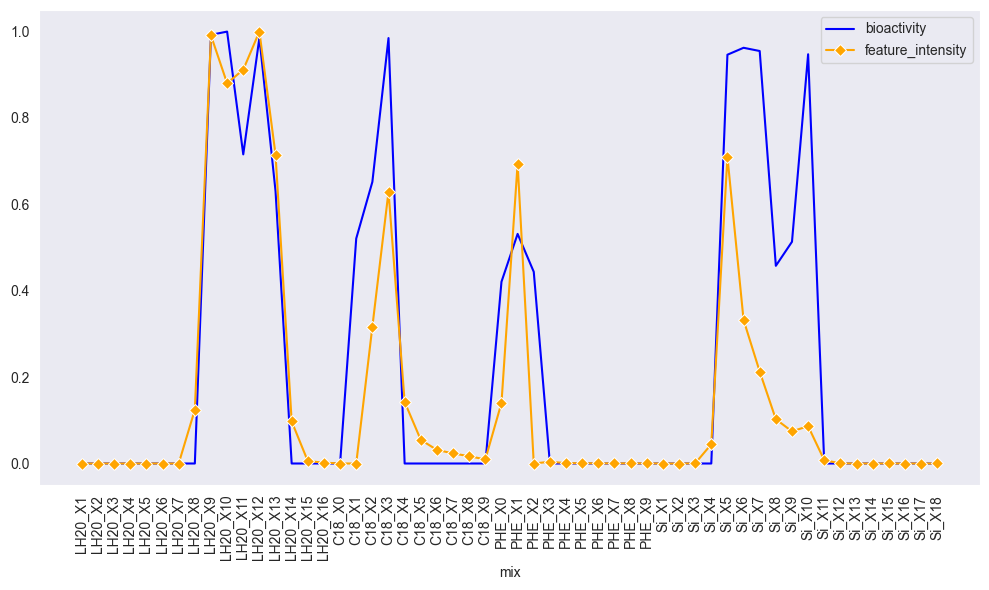

In [18]:
bioactivity_figs(correlation_result, bio_data_processed, 6, save_dir=alignment_dir)

# generating figures in batch mode (top n ranked)

In [20]:
bioacitivity_figs_batch(correlation_result, bio_data_processed, top_n=10, save_dir=alignment_dir)

# export to sirius_compitable files

In [ ]:
from toolsets.file_io import export_mgf_shortlist
topn = 100

for index, row in correlation_result.iterrows():
    export_mgf_shortlist(row, output_dir=bio_dir)

# below is assuming different compound in different columns

In [115]:
picked= []
correlation_result = {}
for index, row in active_fractions.iterrows():
    if active_fractions.loc[index]['mix'] not in picked:
        peak_idx = index
        left_edge, right_edge = find_edge(bio_data_processed['average_adjusted'], peak_idx=index)
        picked.extend(bio_data_processed['mix'][left_edge:right_edge+1])
        activity_temp = list(np.repeat(0, len(bio_data_processed)))
        activity_temp[left_edge:right_edge+1]=bio_data_processed['average_adjusted'][left_edge:right_edge+1]
        correlation = []
        p_values = []
        for index, row in alignment_fractions.iterrows():
            temp = (pearsonr(row.values, activity_temp))
            if temp[0]!=temp[0]: # this is nan
                correlation.append(0)
                p_values.append(0)
            else:
                correlation.append(temp[0])
                p_values.append(temp[1])
        correlation_result_temp = alignment_mzrt.copy()
        correlation_result_temp['pearson'] = correlation
        correlation_result_temp['p_values']=p_values
        correlation_result[bio_data_processed['mix'].iloc[index]]=correlation_result_temp

        # print(left_edge, right_edge)
        # for i in range(left_edge,right_edge+1):
        #     activity_temp[i]=bio_data_processed['average_adjusted'][i]
        break
        # print(left_edge, right_edge)
        # break
    # break

IndexError: single positional indexer is out-of-bounds

In [119]:
correlation_result_temp.sort_values(by = ['pearson'], ascending=False, inplace=True)

In [1]:
correlation_result_temp

NameError: name 'correlation_result_temp' is not defined

In [77]:
595.0818-((279.0708-single_charged_adduct_mass['[M+H]+'])*2+38.963158)

-0.008406000000036329

In [105]:
279.0708-single_charged_adduct_mass['[M+H]+']

278.06352400000003

In [78]:
(279.0708-single_charged_adduct_mass['[M+H]+'])*2+single_charged_adduct_mass['[M+Na]+']

579.1162660000001

In [76]:
279.0708-single_charged_adduct_mass['[M+H]+']

278.06352400000003

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


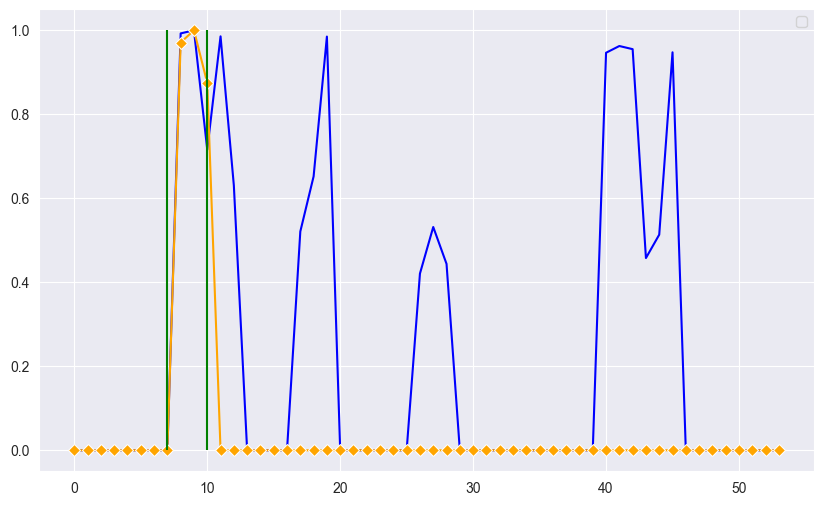

In [145]:
idx = 18341
fig, axs = plt.subplots(figsize = (10,6))
sns.lineplot(x =  np.arange(len(bio_data_processed)), y = [x/bio_data_processed['average_adjusted'].max() for x in bio_data_processed['average_adjusted']], color = 'blue')
sns.lineplot(x =  np.arange(len(bio_data_processed)), y = [x/alignment_istd_cleaned.loc[idx][mix_name_pos].max() for x in alignment_istd_cleaned.loc[idx][mix_name_pos]], color = 'orange', marker = 'D')

# plt.legend()
plt.vlines(x = 7, ymin = 0, ymax = 1, colors='green')
plt.vlines(x = 10, ymin = 0, ymax = 1,colors='green')
# plt.xticks(rotation = 90)
plt.show()